图片处理之滤波
===

# 1.噪声

# 1.1.什么是噪声

如果你把图像看作信号，那么噪声就是干扰信号。我们在采集图像时可能因为各种各样的干扰而引入图像噪声。

我们可以把图像看作一个函数，那么带有噪声的图像，就可以看作是原始图像函数与噪声函数相加的和。
$$f(x, y) = I(x, y) + noise$$

## 1.2.噪声的分类
基本上噪声分为高斯噪声和椒盐噪声

高斯噪声(Gaussian noise)是指它的概率密度函数服从高斯分布的一类噪声。如果一个噪声，它的幅度分布服从高斯分布，而它的功率谱密度又是均匀分布的，则称它为高斯白噪声。

常见的噪声有椒盐噪声(salt and pepper noise)。因为图像的像素点由于噪声影响随机变成了黑点(dark spot)或白点(white spot)，很想外国的“胡椒”，胡椒是黑色的，盐是白色的

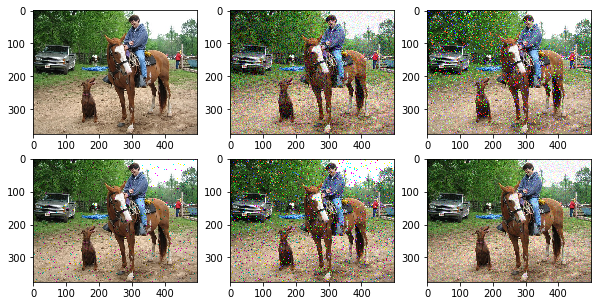

In [13]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su

img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
row, column, channel = img.shape
 
plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(2, 3, 1) 
plt.imshow(img)

plt.subplot(2, 3, 2)
plt.imshow(su.random_noise(img, mode='gaussian'))

plt.subplot(2, 3, 3)
plt.imshow(su.random_noise(img, mode='salt', amount=0.05))

plt.subplot(2, 3, 4)
plt.imshow(su.random_noise(img, mode='pepper', amount=0.01))

plt.subplot(2, 3, 5)
plt.imshow(su.random_noise(img, mode='s&p'))

plt.subplot(2, 3, 6)
plt.imshow(su.random_noise(img, mode='speckle'))

# 2.高斯滤波 - 去除噪声
高斯滤波器是一种可以使图像平滑的滤波器，用于去除噪声。可用于去除噪声的滤波器还有中值滤波器，平滑滤波器、LoG滤波器

高斯滤波器将重心像素周围的像素按照高斯分布加权平均进行平滑化。这样的（二维）权值通常被称为卷积核或者滤波器

但是，由于图像的长宽可能不是滤波器大小的整数倍，因此我们需要在图像的边缘补0。这种方法称作Zero Padding。并且权值（卷积核）要进行归一化操作($\sum g = 1$)。

权值$g(x,y,s)=\frac{1}{s \times \sqrt{2\pi} \times e^{-\frac{x^2+y^2}{2 \times s^2}}}$

标准差s=1.3的8近邻高斯滤波器如下
$$
K=\frac{1}{16} \times \begin{bmatrix}
1&2&1 \\
2&4&2 \\
1&2&1
\end{bmatrix}
$$

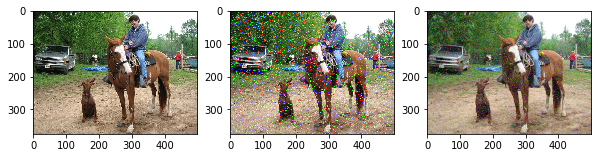

In [5]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np


img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def gaussian_filter(img, K_Size = 3, sigma=1.3):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        img = np.expand_dims(img, axis=-1)
        H, W, C = img.shape
    
	## Zero padding
    pad = K_Size // 2
    out_filter = np.zeros((H + pad * 2, W + pad * 2, C), dtype=np.float)
    out_filter[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)

    ## prepare Kernel
    K = np.zeros((K_Size, K_Size), dtype=np.float)
    for x in range(-pad, -pad + K_Size):
        for y in range(-pad, -pad + K_Size):
            K[y + pad, x + pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    K /= (2 * np.pi * sigma * sigma)
    K /= K.sum()

    tmp = out_filter.copy()

    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out_filter[pad + y, pad + x, c] = np.sum(K * tmp[y: y + K_Size, x: x + K_Size, c])
    out_filter = np.clip(out_filter, 0, 255)
    out_filter = out_filter[pad: pad + H, pad: pad + W].astype(np.uint8)

    return out_filter

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1) 
plt.imshow(img)

plt.subplot(1, 3, 2)
out = su.random_noise(img, mode='salt')
plt.imshow(out)

out_filter = gaussian_filter(out * 255)
plt.subplot(1, 3, 3)
plt.imshow(out_filter)

# 3.中值滤波
中值滤波器是一种可以使图像平滑的滤波器。这种滤波器用滤波器范围内(3x3)像素点的中值进行滤波，在这里也采用Zero Padding

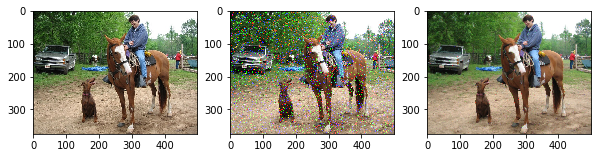

In [7]:
import cv2
import matplotlib.pyplot as plt
import skimage.util as su
import numpy as np


img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def median_filter(img, K_Size = 3):
    H, W, C = img.shape

    ## Zero padding
    pad = K_Size // 2
    out = np.zeros((H + pad*2, W + pad*2, C), dtype=np.float)
    out[pad:pad+H, pad:pad+W] = img.copy().astype(np.float)

    tmp = out.copy()

    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad+y, pad+x, c] = np.median(tmp[y:y+K_Size, x:x+K_Size, c])

    out = out[pad:pad+H, pad:pad+W].astype(np.uint8)

    return out

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1) 
plt.imshow(img)

plt.subplot(1, 3, 2)
out = su.random_noise(img, mode='salt')
plt.imshow(out)

out_filter = median_filter(out * 255)
plt.subplot(1, 3, 3)
plt.imshow(out_filter)

# 4.均值滤波器
均值滤波器是一种可以使图像平滑的滤波器。这种滤波器用滤波器范围内(3x3)像素点的均值进行滤波，在这里也采用Zero Padding

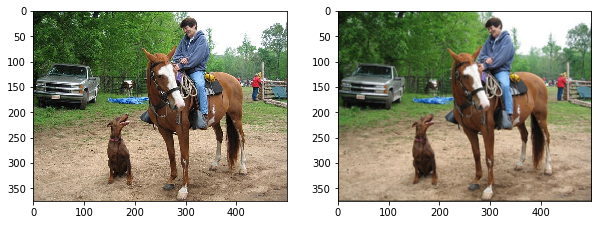

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def mean_filter(img, K_Size = 3):
    H, W, C = img.shape

    ## Zero padding
    pad = K_Size // 2
    out = np.zeros((H + pad*2, W + pad*2, C), dtype=np.float)
    out[pad:pad+H, pad:pad+W] = img.copy().astype(np.float)

    tmp = out.copy()

    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad+y, pad+x, c] = np.mean(tmp[y:y+K_Size, x:x+K_Size, c])

    out = out[pad:pad+H, pad:pad+W].astype(np.uint8)

    return out

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(img)

out_filter = mean_filter(img)
plt.subplot(1, 2, 2)
plt.imshow(out_filter)

# 5.Motion滤波

Motion Filter取对角线方向的像素的平均值，卷积核为$\begin{bmatrix}
\frac{1}{3}&0&0 \\
0&\frac{1}{3}&0 \\
0&0&\frac{1}{3}
\end{bmatrix}$

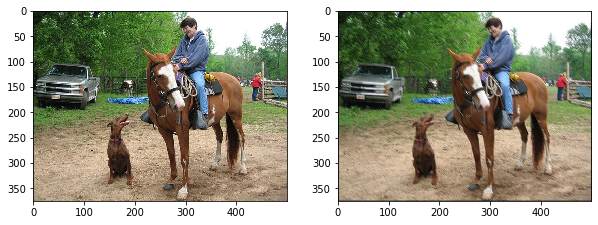

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


img = cv2.imread("Images/01/09/02.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def motion_filter(img, K_Size = 3):
    H, W, C = img.shape
    
    K = np.diag([1] * K_Size).astype(np.float)
    K /= K_Size
    
    ## Zero padding
    pad = K_Size // 2
    out = np.zeros((H + pad*2, W + pad*2, C), dtype=np.float)
    out[pad:pad+H, pad:pad+W] = img.copy().astype(np.float)

    tmp = out.copy()

    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad+y, pad+x, c] = np.sum(K * tmp[y:y+K_Size, x:x+K_Size, c])

    out = out[pad:pad+H, pad:pad+W].astype(np.uint8)

    return out

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 2, 1) 
plt.imshow(img)

out_filter = motion_filter(img)
plt.subplot(1, 2, 2)
plt.imshow(out_filter)

# 6.MAX-MIN滤波器

MAX-MIN滤波器使用网格内像素的最大值和最小值的差值对网格内像素重新赋值。

通常用于边缘检测。边缘检测用于检测图像中的线。像这样提取图像中的信息的操作被称为特征提取。边缘检测通常在灰度图像上进行

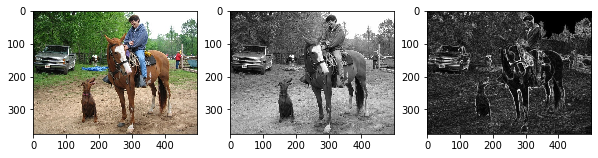

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img = cv2.imread("Images/01/09/02.jpg")

b = img[:, :, 0].copy()
g = img[:, :, 1].copy()
r = img[:, :, 2].copy()

# Gray scale
out = 0.2126 * r + 0.7152 * g + 0.0722 * b
out = out.astype(np.uint8)

def max_min_filter(img, K_size=3):
	H, W = img.shape

	## Zero padding
	pad = K_size // 2
	out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
	out[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)
	tmp = out.copy()

	# filtering
	for y in range(H):
		for x in range(W):
			out[pad + y, pad + x] = np.max(tmp[y: y + K_size, x: x + K_size]) - np.min(tmp[y: y + K_size, x: x + K_size])

	out = out[pad: pad + H, pad: pad + W].astype(np.uint8)

	return out

plt.figure(figsize=(10,5), facecolor='w')
plt.subplot(1, 3, 1)
show_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img1)

plt.subplot(1, 3, 2)
show_img2 = cv2.cvtColor(out, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

plt.subplot(1, 3, 3)
out = max_min_filter(out)
show_img2 = cv2.cvtColor(out, cv2.COLOR_BGR2RGB) 
plt.imshow(show_img2)

# 7.微分滤波器
微分滤波器对图像亮度急剧变化的边缘有提取效果，可以获得邻接像素的差值。纵向使用$\begin{bmatrix}
0&-1&0 \\
0&1&0 \\
0&0&0
\end{bmatrix}$，横向使用$\begin{bmatrix}
0&0&0 \\
-1&1&0 \\
0&0&0
\end{bmatrix}$

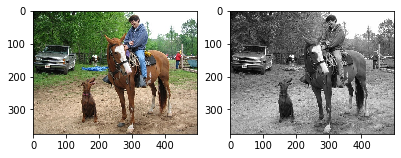

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

image = cv2.imread("Images/01/09/02.jpg")

b = image[:, :, 0].copy()
g = image[:, :, 1].copy()
r = image[:, :, 2].copy()
out = 0.2126 * r + 0.7152 * g + 0.0722 * b
out = out.astype(np.uint8)

plt.figure(figsize=(10,8), facecolor='white')
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))



# 8.Sobel滤波器

# 9.Prewitt滤波器

# 10.Laplacian滤波器

# 11.Emboss滤波器

# 12.LoG滤波器